In [1]:
import sys
sys.path.append("..")
%cd ..

/Users/AsgerSturisTang/OneDrive - Danmarks Tekniske Universitet/DTU/6. Semester/Bachelor2021


In [2]:
from scipy.stats import norm
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import r2_score, mean_squared_error
from DataPrep.ImportData import importer
from Tobit import Tobit


In [3]:
df = importer().Import()

In [4]:
testdata = df[df.Label == 0.0]


In [5]:
testdata = testdata.drop(columns=["Charging Time (mins)","Total Duration (mins)"])

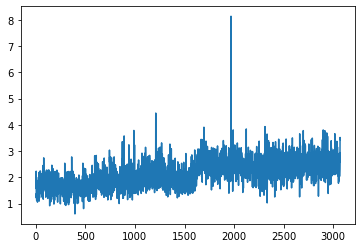

In [6]:
plt.plot(testdata["Energy (kWh)"])

In [7]:
def censor(s):
    energy = s["Energy (kWh)"] 
    energy_lag1 = s["Energy (kWh)_lag1"]
    energy_lag2 = s["Energy (kWh)_lag2"]
    energy_lag3 = s["Energy (kWh)_lag3"]
    energy_lag4 = s["Energy (kWh)_lag4"]
    energy_lag5 = s["Energy (kWh)_lag5"]

    s["Censored"] = False
    if energy > 3:
        s["Energy (kWh)"] = 3
        s["Censored"] = True
    if energy_lag1 > 3:
        s["Energy (kWh)_lag1"] = 3
    if energy_lag2 > 3:
        s["Energy (kWh)_lag2"] = 3
    if energy_lag3 > 3:
        s["Energy (kWh)_lag3"] = 3
    if energy_lag4 > 3:
        s["Energy (kWh)_lag4"] = 3
    if energy_lag5 > 3:
        s["Energy (kWh)_lag5"] = 3
    
    return s

In [8]:
testdata = testdata.apply(censor, axis=1)

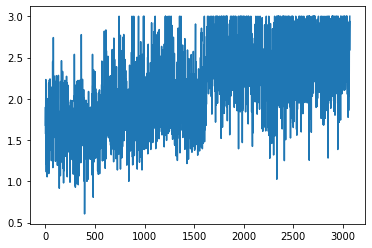

In [9]:
plt.plot(testdata["Energy (kWh)"])

In [10]:
testdata[testdata["Censored"] == False].shape

(2927, 84)

In [11]:
t = Tobit(testdata, 'Censored', ["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"], 'Energy (kWh)')

In [12]:
regressor = LinearRegression().fit(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]), testdata["Energy (kWh)"])
pred = regressor.predict(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]))

In [57]:
vars = regressor.coef_


In [58]:
vars = np.append(vars,1)

In [97]:
vars = np.array([0.5,0.5,0.5,0.5,0.5,1])

In [98]:
minimizer = t.minimize(vars)

In [99]:
minimizer["x"]

array([0.21622137, 0.21020018, 0.19579041, 0.22213668, 0.17212602,
       1.11387415])

In [105]:
from tqdm import tqdm

In [109]:
_mins = []
_i = []
_j = []
_k = []
_a = []
_b = []
with tqdm(total=3**5, file=sys.stdout) as pbar:
    for i in np.linspace(0.1,1,3):
        for j in np.linspace(0.1,1,3):
            for k in np.linspace(0.1,1,3):
                for a in np.linspace(0.1,1,3):
                    for b in np.linspace(0.1,1,3):
                        vars = np.array([i,j,k,a,b,1])
                        mins = t.minimize(vars)
                        if mins.x[-1] > 0:
                            _mins.append(vars)
                            _i.append(i)
                            _j.append(j)
                            _k.append(k)
                            _a.append(a)
                            _b.append(b)
                        pbar.update(1)


100%|██████████| 243/243 [11:37<00:00,  2.87s/it]


In [114]:
_mins

[array([0.1, 0.1, 0.1, 0.1, 0.1, 1. ]),
 array([0.1 , 0.1 , 0.1 , 0.1 , 0.55, 1.  ]),
 array([0.1, 0.1, 0.1, 0.1, 1. , 1. ]),
 array([0.1 , 0.1 , 0.1 , 0.55, 0.1 , 1.  ]),
 array([0.1 , 0.1 , 0.1 , 0.55, 0.55, 1.  ]),
 array([0.1 , 0.1 , 0.1 , 0.55, 1.  , 1.  ]),
 array([0.1, 0.1, 0.1, 1. , 0.1, 1. ]),
 array([0.1 , 0.1 , 0.1 , 1.  , 0.55, 1.  ]),
 array([0.1, 0.1, 0.1, 1. , 1. , 1. ]),
 array([0.1 , 0.1 , 0.55, 0.1 , 0.1 , 1.  ]),
 array([0.1 , 0.1 , 0.55, 0.1 , 0.55, 1.  ]),
 array([0.1 , 0.1 , 0.55, 0.1 , 1.  , 1.  ]),
 array([0.1 , 0.1 , 0.55, 0.55, 0.1 , 1.  ]),
 array([0.1 , 0.1 , 0.55, 0.55, 0.55, 1.  ]),
 array([0.1 , 0.1 , 0.55, 0.55, 1.  , 1.  ]),
 array([0.1 , 0.1 , 0.55, 1.  , 0.1 , 1.  ]),
 array([0.1 , 0.1 , 0.55, 1.  , 0.55, 1.  ]),
 array([0.1, 0.1, 1. , 0.1, 0.1, 1. ]),
 array([0.1 , 0.1 , 1.  , 0.1 , 0.55, 1.  ]),
 array([0.1, 0.1, 1. , 0.1, 1. , 1. ]),
 array([0.1 , 0.1 , 1.  , 0.55, 0.1 , 1.  ]),
 array([0.1 , 0.1 , 1.  , 0.55, 0.55, 1.  ]),
 array([0.1, 0.1, 1. , 1

In [112]:
pd.DataFrame({"l2":_j,"l3":_k,"l4":_a,"l5":_b})

,l2,l3,l4,l5
0,0.10,0.10,0.10,0.10
1,0.10,0.10,0.10,0.55
2,0.10,0.10,0.10,1.00
3,0.10,0.10,0.55,0.10
4,0.10,0.10,0.55,0.55
...,...,...,...,...
91,0.55,0.10,0.10,0.10
92,0.55,0.10,0.10,0.55
93,0.55,0.10,0.55,0.10
94,0.55,0.55,0.10,0.10


In [121]:
for i in _mins:
    m = t.minimize(i)
    print(i)
    print(m.x)
    

[0.1 0.1 0.1 0.1 0.1 1. ]
[0.21621936 0.21020688 0.1957836  0.22213584 0.17212956 1.11387057]
[0.1  0.1  0.1  0.1  0.55 1.  ]
[0.2162201  0.21020784 0.19578171 0.22213517 0.17213004 1.11387202]
[0.1 0.1 0.1 0.1 1.  1. ]
[0.21622004 0.21020775 0.19578164 0.22213503 0.17213043 1.11387195]
[0.1  0.1  0.1  0.55 0.1  1.  ]
[0.21621994 0.21020788 0.19578173 0.22213487 0.17213019 1.11387203]
[0.1  0.1  0.1  0.55 0.55 1.  ]
[0.21622    0.21020782 0.19578159 0.22213524 0.17213025 1.11387195]
[0.1  0.1  0.1  0.55 1.   1.  ]
[0.21622008 0.21020774 0.19578164 0.22213507 0.17213037 1.11387199]
[0.1 0.1 0.1 1.  0.1 1. ]
[0.21621983 0.21020773 0.19578151 0.22213569 0.17213018 1.11387221]
[0.1  0.1  0.1  1.   0.55 1.  ]
[0.21622095 0.21020596 0.1957819  0.22213663 0.17212927 1.11387092]
[0.1 0.1 0.1 1.  1.  1. ]
[0.21622158 0.21020635 0.19578163 0.22213638 0.17212902 1.11387196]
[0.1  0.1  0.55 0.1  0.1  1.  ]
[0.21622    0.21020772 0.19578153 0.22213515 0.1721304  1.11387208]
[0.1  0.1  0.55 0.1  0.5

In [87]:
sd = minimizer['x'][-1]
beta = minimizer['x'][:-1]

In [88]:
sd

1.1138741482400678

In [63]:
beta

array([0.21622023, 0.210208  , 0.19578188, 0.22213458, 0.1721302 ])

In [64]:
regressor.coef_

array([0.18107919, 0.16463001, 0.16186996, 0.17187732, 0.13269433])

In [89]:
pred_tobit = t.predict(np.array(testdata[["Energy (kWh)_lag1","Energy (kWh)_lag2","Energy (kWh)_lag3","Energy (kWh)_lag4","Energy (kWh)_lag5"]]),beta)

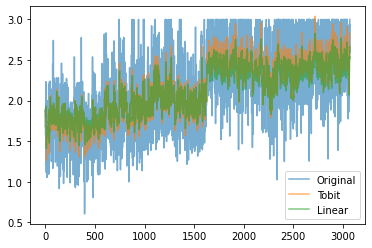

In [90]:
plt.plot(testdata["Energy (kWh)"], label = "Original", alpha = 0.6)
plt.plot(pred_tobit, label = "Tobit", alpha = 0.6)
plt.plot(pred, label = "Linear", alpha = 0.6)

plt.legend()
plt.show()

In [67]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)], pred_tobit))

0.41696040688718805

In [68]:
np.sqrt(mean_squared_error(df["Energy (kWh)"][(df.Label == 0.0)], pred))

0.4119549438339677

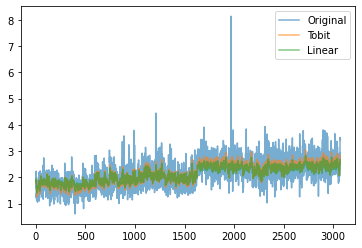

In [69]:
plt.plot(df["Energy (kWh)"][df.Label == 0.0], label = "Original", alpha = 0.6)
plt.plot(pred_tobit, label = "Tobit", alpha = 0.6)
plt.plot(pred, label = "Linear", alpha = 0.6)

plt.legend()
plt.show()

In [70]:
r2_score(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.33312099332618184

In [71]:
r2_score(df["Energy (kWh)"][df.Label == 0.0], pred)

0.34903618424857996

In [28]:
from sklearn.metrics import mean_absolute_error



In [29]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.3165387656320173

In [30]:
mean_absolute_error(df["Energy (kWh)"][df.Label == 0.0], pred)

0.31109770821282523

In [31]:
mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred_tobit)

0.1738560036810394

In [32]:
mean_squared_error(df["Energy (kWh)"][df.Label == 0.0], pred)

0.16970687574924748